## Import libraries & load dataframe in python env

In [63]:
#import the library 
import pandas as pd
import os

import math
from scipy.stats import skew 

from matplotlib import pyplot as plt
import seaborn as sns

## Step 1: Data formatting

In [18]:
#how to know that transfer to txt file?==> note for this part

path = "/Users/apple/Downloads/books.csv"

with open(path, 'r',encoding='utf-8') as f_in, open('temp.txt', 'w',encoding='utf-8') as f_out:
    # 2. Read the CSV file and store in variable
    content = f_in.read()
    print(content.count(','))
    # 3. Write the content into the TXT file
    f_out.write(content)

122408


Here, we need to deal with the fact that the csv file is malformed : the values are comma separated, but one field contains commas on some lines, which causes the lines of the dataframe to be shifted. A quick inspection of the data in excel shows that they are all in the same column, "authors". So, we shall proceed in the following way :

* loop through each line in the original csv as if it were a txt file
* count total comma separated blocks in that line. If it is greater than 12, it means we have extra commas in the author column, and the difference lets us know how many of the next comma seperated values should be grouped together
* once grouped appropriately, grouped blocks get "" added around them so that the csv file can be properly formated
* a new csv is created from this modified file, which is then loaded into the dataframe
* the intermediate text and csv files are removed since they are no longer needed. We have now grouped all our data in a dataframe despite the malformation of the csv file.

In [19]:
file1 = open(path, 'r',encoding='utf-8')
lines = file1.readlines()
modlines=[]
for line in lines:
    line_elements=line.split(',')
    s=''
    for i in range(2):
        s=s+'"'+line_elements[i]+'",'
    t=''
    for i in range(2,3+len(line_elements)-12):
        t=t+line_elements[i]+','
    t=t[:-1]
    s=s+'"'+t+'",'
    for i in range(3+len(line_elements)-12,len(line_elements)):
        s=s+'"'+line_elements[i]+'",'
    s=s.replace('\n','')
    s=s[:-1]
    s=s+'\n'
    modlines.append(s)

file1 = open('out.csv','w',encoding='utf-8')
file1.writelines(modlines)
file1.close()

df=pd.read_csv('out.csv')

os.remove('temp.txt')
os.remove('out.csv')


In [20]:
#Check the dataframe after processing: 
df.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,9/16/06,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,9/1/04,Scholastic Inc.


In [34]:
#The code below will delete the extra whitespace in the columns that have string data type.
df.rename(columns=lambda x: x.strip(), inplace=True)

In [ ]:
#? check published date to know to need the format or no

## Step 2: Data exploration

In [35]:
#See the shape of dataframe
df.shape

(11127, 12)

In [49]:
# check the duplicated values
df.duplicated().any()

False

In [37]:
#Type of each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  float64
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 1.0+ MB


There are two types of variables: continuous and categorical. lets describe each of group variables
* Group 1: continuous variables: average_rating, isbn, isbn13, num_pages, ratings_count, text_reviews_count
* Group 2: categorical variables: title, authors, language_code, publisher

In [141]:
# Describe continuous variables: 
cont_vars = ['average_rating', 'isbn', 'isbn13', 'num_pages', 'ratings_count', 'text_reviews_count']
df[cont_vars].describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,10971.000000,1.097100e+04,10971.000000,1.097100e+04,10971.000000
mean,3.943235,9.758875e+12,339.064990,1.818883e+04,549.457205
std,0.294536,4.459933e+11,240.173871,1.132562e+05,2593.630924
min,1.000000,8.987060e+09,1.000000,1.000000e+00,0.000000
25%,3.780000,9.780000e+12,197.000000,1.130000e+02,10.000000
50%,3.960000,9.780000e+12,302.000000,7.810000e+02,48.000000
75%,4.140000,9.780000e+12,416.000000,5.138000e+03,244.000000
max,5.000000,9.790000e+12,6576.000000,4.597666e+06,94265.000000


Notes: average_rating  = 0, num_pages = 0, ratings_count = 0, text_reviews_count = 0
        
Here, we see that some columns that are not supposed to have 0-values in them do. For example, the goodreads does not allow rating of 0, but some books in the data have an average rating of 0. Moreover, some books have 0 pages, which is not possible. Also, if a book has 0 ratings, it makes no sense to assign a rating to it. It may have no text ratings, however, as long as it has at least one rating. so, we need to notice these issues in the data cleaning process.

In [39]:
# Describe categorical variales:
cat_vars = ['title', 'authors', 'language_code', 'publisher']
df[cat_vars].describe()

,title,authors,language_code,publisher
count,11127,11127,11127,11127
unique,10352,6643,27,2292
top,The Brothers Karamazov,Stephen King,eng,Vintage
freq,9,40,8911,318


## Step 3: Data cleaning

In [4]:
#check missing value
df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

There is no "official" missing value in the dataset (column with NaN value), it does not mean that there is no issues in the dataset. As we explained in the data exploration part, the correct dataset is when average rate is >=1, number of pages > 0, and ratings_count > 0

In [43]:
#Filter data.
df=df[(df['average_rating']>=1) & (df['num_pages']>0) & (df['ratings_count']>0)]
df[cont_vars].describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,10971.000000,1.097100e+04,10971.000000,1.097100e+04,10971.000000
mean,3.943235,9.758875e+12,339.064990,1.818883e+04,549.457205
std,0.294536,4.459933e+11,240.173871,1.132562e+05,2593.630924
min,1.000000,8.987060e+09,1.000000,1.000000e+00,0.000000
25%,3.780000,9.780000e+12,197.000000,1.130000e+02,10.000000
50%,3.960000,9.780000e+12,302.000000,7.810000e+02,48.000000
75%,4.140000,9.780000e+12,416.000000,5.138000e+03,244.000000
max,5.000000,9.790000e+12,6576.000000,4.597666e+06,94265.000000


Check outliers for each variable: 

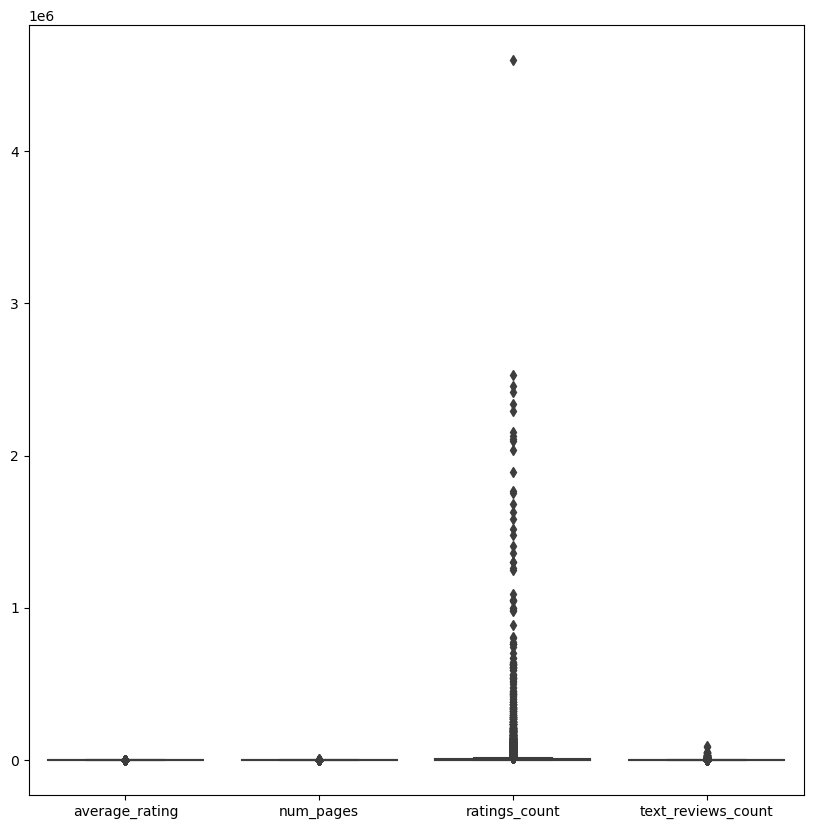

In [118]:
#check outliers for the quantitative variables

df1 = df[["average_rating", "num_pages", "ratings_count", "text_reviews_count"]]

plt.figure(figsize = (10, 10))
sns.boxplot(df1)
plt.show()

In [127]:
#ratings_count seemly has a lot of outlier over 1 000 000 ratings 
df["ratings_count"].count()

10971

In [129]:
#ratings_count seemly has a lot of outlier over 1.000.000 ratings 

print ("The total number of ratings the book received > 1 000 000 ratings")
df[df["ratings_count"]> 1000000].count()

The total number of ratings the book received <=1.000.000 ratings


bookID                30
title                 30
authors               30
average_rating        30
isbn                  30
isbn13                30
language_code         30
num_pages             30
ratings_count         30
text_reviews_count    30
publication_date      30
publisher             30
dtype: int64

The total of number of ratings the book received >1.000.000 is 30, its quite small number
compared to almost book rating received under <= 1.000.000, so its better to remove these value over 1.000.0000 

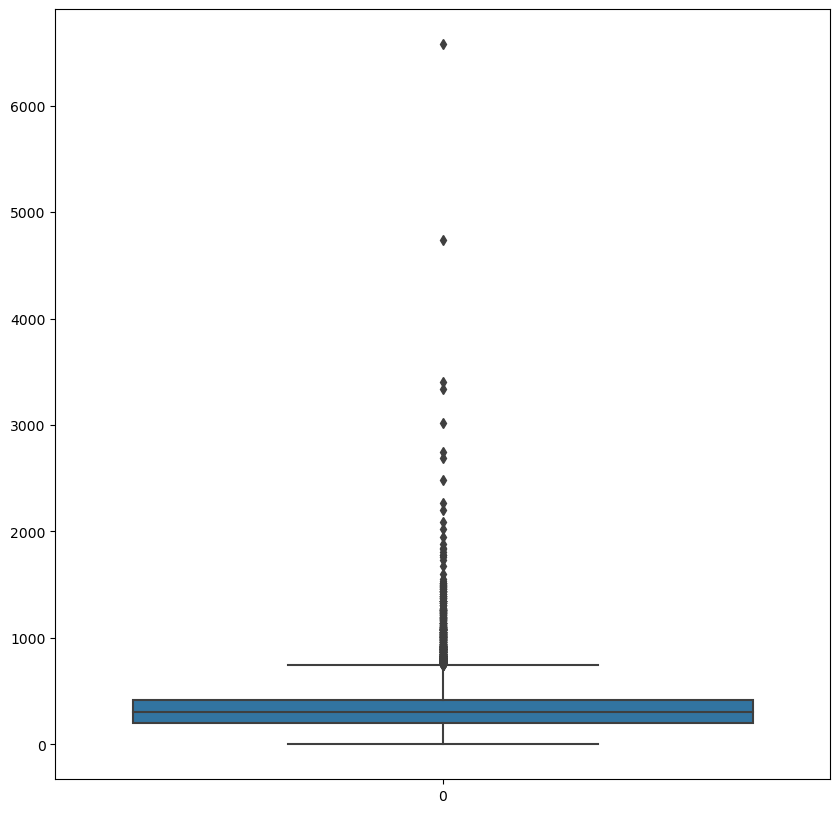

In [131]:
plt.figure(figsize = (10, 10))
sns.boxplot(df["num_pages"])
plt.show()

Go into detailed the number of pages: its better to drop the values over 1000 pages. 

## Step 4: Data processing

### Describe dataset

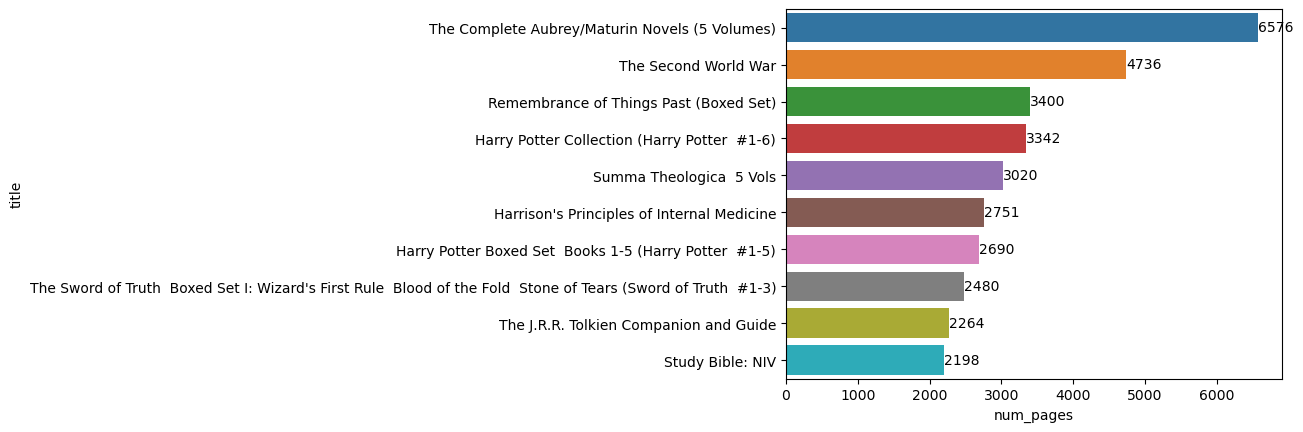

In [211]:
# Top 10 longest book 
top10_longestbook = df.nlargest(10, ['num_pages'])

ax = sns.barplot(top10_longestbook, x= "num_pages", y ="title")

for i in ax.containers: 
    ax.bar_label(i,)

<Axes: xlabel='ratings_count', ylabel='title'>

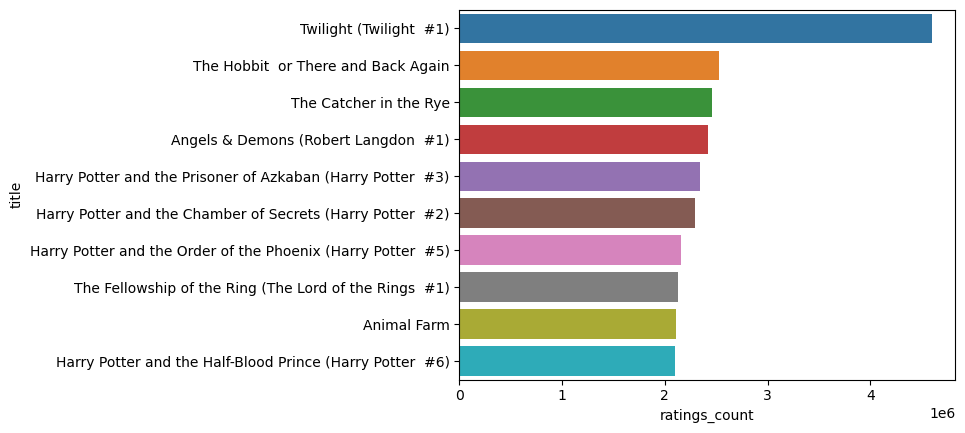

In [194]:
#Q1: Top 10 books receveid the most rating

top10_ratedbook = df.nlargest(10, ['ratings_count'])

# barplot (note: the largest rating will have blue colors, others: greeen)

sns.barplot(top10_ratedbook, x= "ratings_count", y ="title")

<Axes: xlabel='ratings_count', ylabel='title'>

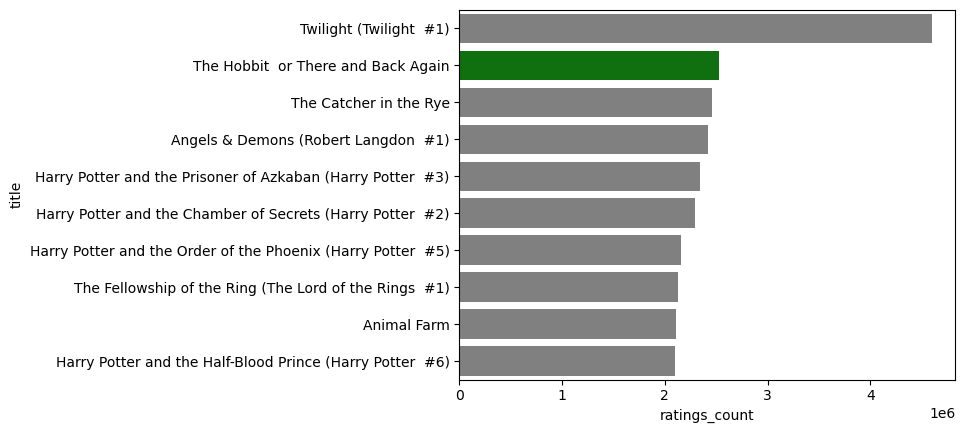

In [201]:
#Q1: Top 10 books receveid the most rating

top10_ratedbook = df.nlargest(10, ['ratings_count'])

# barplot (note: the largest rating will have blue colors, others: greeen)

cols = ["grey" if (x < max(top10_ratedbook)) else "green" for x in top10_ratedbook]

sns.barplot(top10_ratedbook, x= "ratings_count", y ="title", palette = cols)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


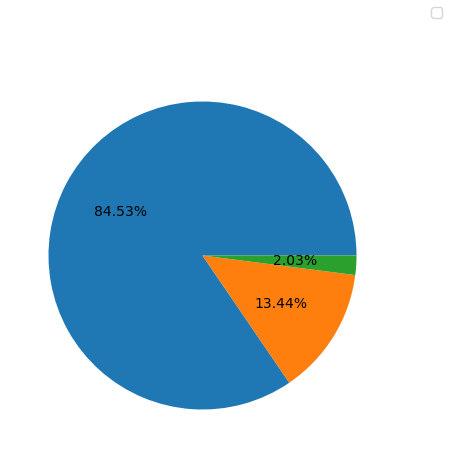

In [259]:
#Top 3 language book: ??? not yet show label??/
plt.figure(figsize=(5,5)).legend()


plt.pie(df["language_code"].value_counts().head(3), autopct='%1.2f%%')
plt.show()

# Check linear regression

- output variable (dependent variable): average_rating

- input variables (independent variables): language_code, num_pages, ratings_count, text_reviews_count, publication_date.  

The 1st model we want to test with dataset is linear regression. Before running this model, we will check the 4 key
assumptions of linear regression. If we see any violated assumptions, we should notice when intepret results as well as test another model.

The 04 main assumptions of linear regression are: 
(X= indepedent variables; Y = dependent variables). 

* 1) Linearity: The relationship between X and the mean of Y is linear.
* 2) Homoscedasticity: The variance of residual is the same for any value of X.
* 3) Independence: Observations are independent of each other.
* 4) Normality: For any fixed value of X, Y is normally distributed.

Source: Simple Linear Regression, Boston University School of Public Health

<Axes: xlabel='num_pages', ylabel='average_rating'>

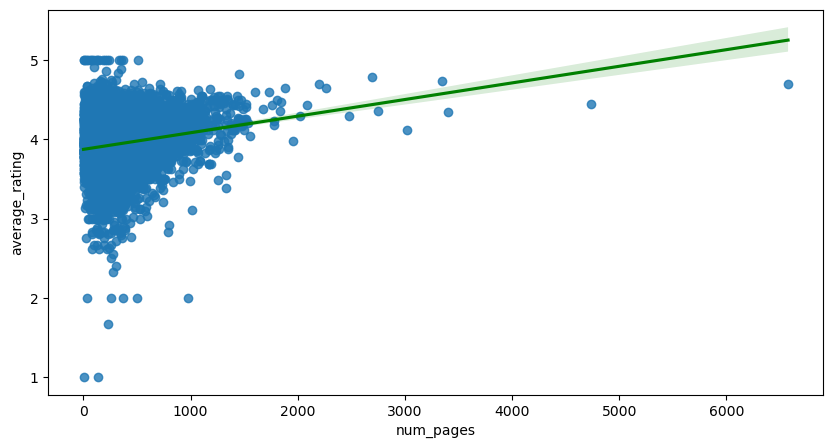

In [231]:
#check condition 1: Linearity
# average_rating & num_pages

plt.figure(figsize=(10,5))
sns.regplot(data = df, x = "num_pages", y = "average_rating", line_kws ={"color" : "green"})

<Axes: xlabel='ratings_count', ylabel='average_rating'>

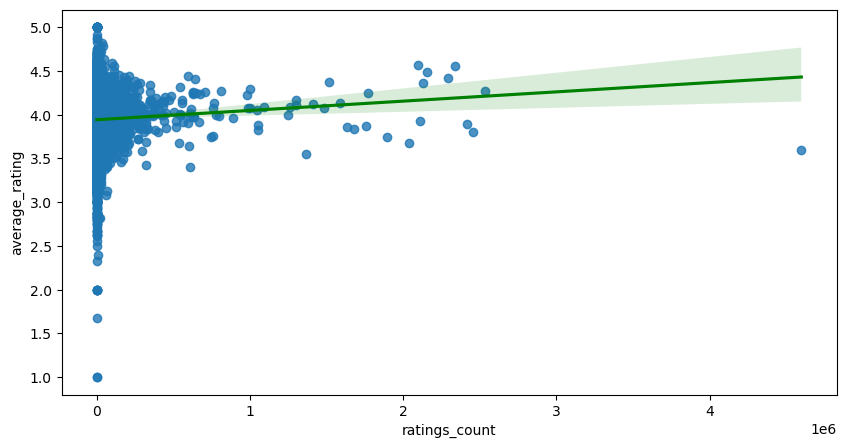

In [232]:
#check condition 1: Linearity
# average_rating & ratings_count

plt.figure(figsize=(10,5))
sns.regplot(data = df, x = "ratings_count", y = "average_rating", line_kws ={"color" : "green"})

<Axes: xlabel='text_reviews_count', ylabel='average_rating'>

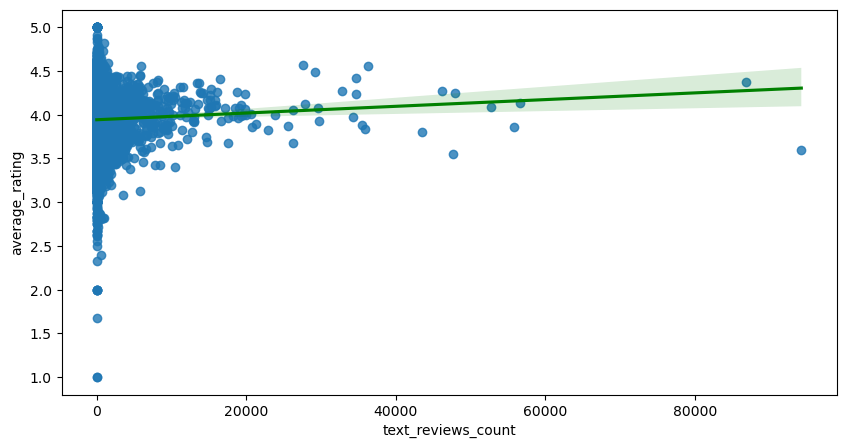

In [233]:
#check condition 1: Linearity
# average_rating & ratings_count

plt.figure(figsize=(10,5))
sns.regplot(data = df, x = "text_reviews_count", y = "average_rating", line_kws ={"color" : "green"})

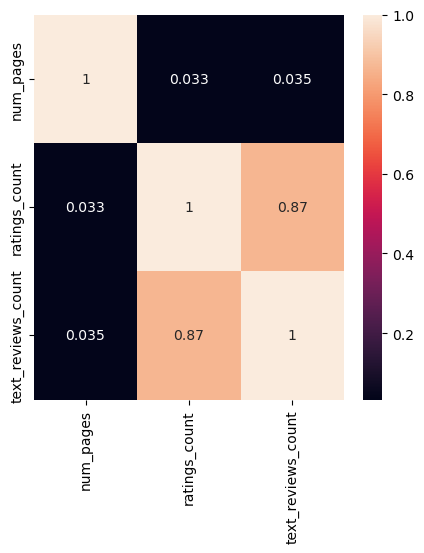

In [228]:
#check condition 3: Independence
df1 = df[["num_pages", "ratings_count", "text_reviews_count"]]

plt.figure(figsize = (5,5))
sns.heatmap(df1.corr(), annot= True)
plt.show()

02 variables: ratings_count & text_reviews_count have strong correlation (87%),
so the linear regression SHOULD NOT include both variables. 
It we try to add both variables in these models, the final correlation is definetly affected by the relation between ratings_count & text_reviews_count 

array([[<Axes: title={'center': 'average_rating'}>,
        <Axes: title={'center': 'num_pages'}>],
       [<Axes: title={'center': 'ratings_count'}>,
        <Axes: title={'center': 'text_reviews_count'}>]], dtype=object)

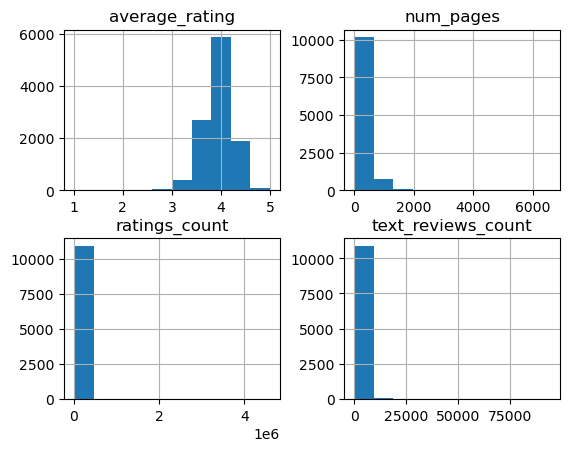

In [146]:
#check the condition 4: normality 
df1.hist()

num_pages, ratings_count, text_reviews_count: skewed histogram=> not normalized distribution => violated conditions=> NOT Linear regression . 

/var/folders/fg/f4npy5xn4zq3j7653py70f_r0000gn/T/ipykernel_43709/2277652540.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["average_rating"], shade = True)


<Axes: xlabel='average_rating', ylabel='Density'>

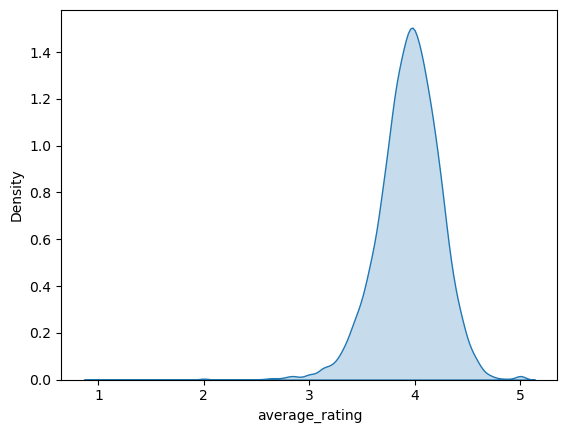

In [147]:
# check average_rating: one more time
sns.kdeplot(df["average_rating"], shade = True)

average_rating: normalized distribution

### LINEAR REGRESSIONS IS NOT OPTIMAL CHOICE WITH THESE VARIABLES